<a href="https://colab.research.google.com/github/Magferat/p2_models/blob/main/Deepfake_Detection_with_Rawnet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchaudio matplotlib scikit-learn tqdm ipywidgets notebook soundfile audioread librosa seaborn


In [2]:
# Standard libraries
import os
import random
import math
import pickle

# Numerical and data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.utils import data
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from collections import OrderedDict

# Torchaudio
import torchaudio
import torchaudio.transforms as T

# Display
import IPython.display as ipd

# Sklearn metrics and tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    precision_recall_curve, average_precision_score,
    roc_curve, confusion_matrix
)

# SciPy for EER calculation
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# Progress bar
from tqdm import tqdm


import librosa


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
dataset_path = '/content/drive/MyDrive/Dataset'
# dataset_path = r"C:\Users\T2420353\detect_dp_fk_24\Dataset"

train_path = os.path.join(dataset_path, 'Train')
test_path = os.path.join(dataset_path, 'Test')


In [ ]:
import os
print(os.listdir(train_path)[:10])
print(os.listdir(test_path)[:10])


['Fake_vc_C51_B_018.wav', 'Fake_vc_C51_B_007.wav', 'Fake_vc_C51_B_005.wav', 'Fake_vc_C51_B_006.wav', 'Fake_vc_C51_B_002.wav', 'Fake_vc_C51_B_003.wav', 'Fake_vc_C51_B_004.wav', 'Fake_vc_C51_B_014.wav', 'Fake_vc_C51_B_020.wav', 'Fake_vc_C51_B_009.wav']
['Real_M_P29_E_018.wav', 'Real_M_P29_E_017.wav', 'Real_M_P29_E_010.wav', 'Real_M_P29_E_012.wav', 'Real_M_P29_E_001.wav', 'Real_M_P29_E_009.wav', 'Real_M_P29_E_011.wav', 'Real_M_P29_E_013.wav', 'Real_M_P29_E_007.wav', 'Real_M_P29_E_002.wav']


In [5]:
def parse_filename(name):
    name = name.strip()
    if name.startswith('Real'):
        parts = name.replace('.wav', '').split('_')
        return {
            'path': name,
            'label': 0,
            'fake_type': 'Real',
            'gender': 'Female' if parts[1] == 'F' else 'Male',
            'id': parts[2].strip(),
            'set': parts[3].strip(),
            'sentence': int(parts[4])
        }

    elif name.startswith('Fake_tts'):
        parts = name.replace('.wav', '').split('_')
        return {
            'path': name,
            'label': 1,
            'fake_type': 'TTS',
            'gender': 'Female' if parts[2] == 'F' else 'Male',
            'id': parts[3].strip(),
            'set': parts[4].strip(),
            'sentence': int(parts[5])
        }

    elif name.startswith('Fake_vc'):
        parts = name.replace('.wav', '').split('_')
        return {
            'path': name,
            'label': 1,
            'fake_type': 'VC',
            'gender': None,
            'id': parts[2].strip(),
            'set': parts[3].strip(),
            'sentence': int(parts[4])
        }

    else:
        return None


In [6]:


def get_file_df(folder):
    rows = []
    for name in os.listdir(folder):
        if name.endswith('.wav'):
            data = parse_filename(name)
            if data:
                full_path = os.path.join(folder, data['path'])
                try:
                    # wav, sr = librosa.load(full_path, sr=None)
                    wav, sr = librosa.load(full_path, sr=None, res_type='kaiser_fast')
                    duration_sec = len(wav) / sr
                    data['duration'] = duration_sec
                    data['samples'] = len(wav)
                    data['sr'] = sr
                except Exception as e:
                    print(f"Error loading {full_path}: {e}")
                    continue
                data['path'] = full_path  # Use full path now
                rows.append(data)
    return pd.DataFrame(rows)


In [ ]:
df = get_file_df(train_path)
df.to_csv("train_metadata.csv", index=False)


In [ ]:
df = pd.read_csv("train_metadata.csv")
df.head()

,path,label,fake_type,gender,id,set,sentence,duration,samples,sr
0,/content/drive/MyDrive/Dataset/Train/Fake_vc_C...,1,VC,NaN,C51,B,18,5.143208,123437,24000
1,/content/drive/MyDrive/Dataset/Train/Fake_vc_C...,1,VC,NaN,C51,B,7,4.876167,117028,24000
2,/content/drive/MyDrive/Dataset/Train/Fake_vc_C...,1,VC,NaN,C51,B,5,3.413333,81920,24000
3,/content/drive/MyDrive/Dataset/Train/Fake_vc_C...,1,VC,NaN,C51,B,6,4.597583,110342,24000
4,/content/drive/MyDrive/Dataset/Train/Fake_vc_C...,1,VC,NaN,C51,B,2,3.378500,81084,24000


In [7]:



# def pad(x, max_len=64000): #dimdim
#     x_len = x.shape[0]
#     if x_len >= max_len:
#         return x[:max_len]
#     return torch.cat([x] * (max_len // x_len + 1), dim=0)[:max_len]
def pad(x, max_len=64000):
    x_len = x.shape[0]
    if x_len >= max_len:
        return x[:max_len]
    num_repeats = int(max_len / x_len) + 1
    padded_x = np.tile(x.numpy(), num_repeats)[:max_len]
    return torch.tensor(padded_x, dtype=torch.float32)

def init_weights(m):
    if isinstance(m, nn.Linear):
        # torch.nn.init.xavier_uniform(m.weight)
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0001)
    elif isinstance(m, nn.BatchNorm1d):
        pass
    else:
        if hasattr(m, 'weight'):
            nn.init.kaiming_normal_(m.weight, a=0.01)

class AudioDataset(Dataset):
    def __init__(self, dataframe, transform=None, target_sr=16000):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.target_sr = target_sr

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['path']

        # # torchaudio load
        try:
            wav, sr = torchaudio.load(path)
            wav = wav[0]
        except:
          # wav_np, sr = librosa.load(path, sr=None)
          wav_np, sr = librosa.load(path, sr=None, res_type='kaiser_fast')
          wav = torch.tensor(wav_np, dtype=torch.float32)

        # Resample if needed
        if sr != self.target_sr:
            resampler = T.Resample(orig_freq=sr, new_freq=self.target_sr)
            wav = resampler(wav)

        # Silence trim using librosa
        wav_np = wav.numpy()
        wav_trimmed, _ = librosa.effects.trim(wav_np, top_db=20)
        wav = torch.tensor(wav_trimmed, dtype=torch.float32)

        if self.transform:
            wav = self.transform(wav)

        return wav, row['label']


In [ ]:
# Setup
df = pd.read_csv("train_metadata.csv")
df = df.sample(frac=1).reset_index(drop=True)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'])

transform = lambda x: pad(x, max_len=64000)

train_dataset = AudioDataset(train_df, transform=transform)
val_dataset = AudioDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")
print(f"Total dataset length: {len(train_dataset) + len(val_dataset)}")
print(f"dataset length: {len(df)}")


Train dataset length: 4880
Validation dataset length: 1220
Total dataset length: 6100
dataset length: 6100


In [ ]:
import IPython.display as ipd

# Use the internal dataframe from train_dataset (already reset)
df = train_dataset.df

# Get real and fake indices
real_indices = df[df['label'] == 0].index.tolist()
fake_indices = df[df['label'] == 1].index.tolist()

# Sample one from each
real_idx = random.choice(real_indices)
fake_idx = random.choice(fake_indices)

# Get audio + label from dataset
real_audio, real_label = train_dataset[real_idx]
fake_audio, fake_label = train_dataset[fake_idx]

# Get corresponding paths
real_path = df.iloc[real_idx]['path']
fake_path = df.iloc[fake_idx]['path']

# Print and play
print(f"Real Audio | Label: {real_label} | Path: {real_path}")
ipd.display(ipd.Audio(real_audio.numpy(), rate=16000))

print(f"Fake Audio | Label: {fake_label} | Path: {fake_path}")
ipd.display(ipd.Audio(fake_audio.numpy(), rate=16000))


Real Audio | Label: 0 | Path: /content/drive/MyDrive/Dataset/Train/Real_F_P40_B_27.wav


Fake Audio | Label: 1 | Path: /content/drive/MyDrive/Dataset/Train/Fake_tts_M_P3_D_013.wav


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import numpy as np
import math
from torch.utils import data
from collections import OrderedDict
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import pickle
import random

class SincConv(nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)


    def __init__(self, device,out_channels, kernel_size,in_channels=1,sample_rate=16000,
                 stride=1, padding=0, dilation=1, bias=False, groups=1,freq_scale='Mel'):

        super(SincConv,self).__init__()


        if in_channels != 1:

            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels+1
        self.kernel_size = kernel_size
        self.sample_rate=sample_rate

        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size=self.kernel_size+1

        self.device=device
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')


        # initialize filterbanks using Mel scale
        NFFT = 512
        f=int(self.sample_rate/2)*np.linspace(0,1,int(NFFT/2)+1)


        if freq_scale == 'Mel':
            fmel=self.to_mel(f) # Hz to mel conversion
            fmelmax=np.max(fmel)
            fmelmin=np.min(fmel)
            filbandwidthsmel=np.linspace(fmelmin,fmelmax,self.out_channels+2)
            filbandwidthsf=self.to_hz(filbandwidthsmel) # Mel to Hz conversion
            self.freq=filbandwidthsf[:self.out_channels]

        elif freq_scale == 'Inverse-mel':
            fmel=self.to_mel(f) # Hz to mel conversion
            fmelmax=np.max(fmel)
            fmelmin=np.min(fmel)
            filbandwidthsmel=np.linspace(fmelmin,fmelmax,self.out_channels+2)
            filbandwidthsf=self.to_hz(filbandwidthsmel) # Mel to Hz conversion
            self.mel=filbandwidthsf[:self.out_channels]
            self.freq=np.abs(np.flip(self.mel)-1) ## invert mel scale


        else:
            fmelmax=np.max(f)
            fmelmin=np.min(f)
            filbandwidthsmel=np.linspace(fmelmin,fmelmax,self.out_channels+2)
            self.freq=filbandwidthsmel[:self.out_channels]

        self.hsupp=torch.arange(-(self.kernel_size-1)/2, (self.kernel_size-1)/2+1)
        self.band_pass=torch.zeros(self.out_channels-1,self.kernel_size)



    def forward(self,x):
        for i in range(len(self.freq)-1):
            fmin=self.freq[i]
            fmax=self.freq[i+1]
            hHigh=(2*fmax/self.sample_rate)*np.sinc(2*fmax*self.hsupp/self.sample_rate)
            hLow=(2*fmin/self.sample_rate)*np.sinc(2*fmin*self.hsupp/self.sample_rate)
            hideal=hHigh-hLow

            self.band_pass[i,:]=Tensor(np.hamming(self.kernel_size))*Tensor(hideal)

        band_pass_filter=self.band_pass.to(self.device)

        self.filters = (band_pass_filter).view(self.out_channels-1, 1, self.kernel_size)

        return F.conv1d(x, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                         bias=None, groups=1)



class Residual_block(nn.Module):
    def __init__(self, nb_filts, first = False):
        super(Residual_block, self).__init__()
        self.first = first

        if not self.first:
            self.bn1 = nn.BatchNorm1d(num_features = nb_filts[0])

        self.lrelu = nn.LeakyReLU(negative_slope=0.3)

        self.conv1 = nn.Conv1d(in_channels = nb_filts[0], out_channels = nb_filts[1], kernel_size = 3, padding = 1, stride = 1)

        self.bn2 = nn.BatchNorm1d(num_features = nb_filts[1])
        self.conv2 = nn.Conv1d(in_channels = nb_filts[1], out_channels = nb_filts[1], padding = 1, kernel_size = 3, stride = 1)

        if nb_filts[0] != nb_filts[1]:
            self.downsample = True
            self.conv_downsample = nn.Conv1d(in_channels = nb_filts[0], out_channels = nb_filts[1], padding = 0, kernel_size = 1, stride = 1)

        else:
            self.downsample = False
        self.mp = nn.MaxPool1d(3)

    def forward(self, x):
        identity = x
        if not self.first:
            out = self.bn1(x)
            out = self.lrelu(out)
        else:
            out = x

        out = self.conv1(out)
        out = self.bn2(out)
        out = self.lrelu(out)
        out = self.conv2(out)

        if self.downsample:
            identity = self.conv_downsample(identity)

        out += identity
        out = self.mp(out)
        return out





class RawNet(nn.Module):
    def __init__(self, d_args, device):
        super(RawNet, self).__init__()


        self.device=device

        self.Sinc_conv=SincConv(device=self.device, out_channels = d_args['filts'][0], kernel_size = d_args['first_conv'], in_channels = d_args['in_channels'],freq_scale='Mel'
                                    )

        self.first_bn = nn.BatchNorm1d(num_features = d_args['filts'][0])
        self.selu = nn.SELU(inplace=True)
        self.block0 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][1], first = True))
        self.block1 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][1]))
        self.block2 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][2]))
        d_args['filts'][2][0] = d_args['filts'][2][1]
        self.block3 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][2]))
        self.block4 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][2]))
        self.block5 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][2]))
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        self.fc_attention0 = self._make_attention_fc(in_features = d_args['filts'][1][-1], l_out_features = d_args['filts'][1][-1])
        self.fc_attention1 = self._make_attention_fc(in_features = d_args['filts'][1][-1], l_out_features = d_args['filts'][1][-1])
        self.fc_attention2 = self._make_attention_fc(in_features = d_args['filts'][2][-1], l_out_features = d_args['filts'][2][-1])
        self.fc_attention3 = self._make_attention_fc(in_features = d_args['filts'][2][-1], l_out_features = d_args['filts'][2][-1])
        self.fc_attention4 = self._make_attention_fc(in_features = d_args['filts'][2][-1], l_out_features = d_args['filts'][2][-1])
        self.fc_attention5 = self._make_attention_fc(in_features = d_args['filts'][2][-1], l_out_features = d_args['filts'][2][-1])

        self.bn_before_gru = nn.BatchNorm1d(num_features = d_args['filts'][2][-1])
        self.gru = nn.GRU(input_size = d_args['filts'][2][-1], hidden_size = d_args['gru_node'], num_layers = d_args['nb_gru_layer'], batch_first = True)

        self.fc1_gru = nn.Linear(in_features = d_args['gru_node'], out_features = d_args['nb_fc_node'])

        self.fc2_gru = nn.Linear(in_features = d_args['nb_fc_node'], out_features = d_args['nb_classes'],bias=True)

        self.sig = nn.Sigmoid()


    def forward(self, x, y = None,is_test=False):


        nb_samp = x.shape[0]
        len_seq = x.shape[1]
        x=x.view(nb_samp,1,len_seq)

        x = self.Sinc_conv(x)    # Fixed sinc filters convolution
        x = F.max_pool1d(torch.abs(x), 3)
        x = self.first_bn(x)
        x = self.selu(x)

        x0 = self.block0(x)
        y0 = self.avgpool(x0).view(x0.size(0), -1) # torch.Size([batch, filter])
        y0 = self.fc_attention0(y0)
        y0 = self.sig(y0).view(y0.size(0), y0.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x0 * y0 + y0  # (batch, filter, time) x (batch, filter, 1)


        x1 = self.block1(x)
        y1 = self.avgpool(x1).view(x1.size(0), -1) # torch.Size([batch, filter])
        y1 = self.fc_attention1(y1)
        y1 = self.sig(y1).view(y1.size(0), y1.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x1 * y1 + y1 # (batch, filter, time) x (batch, filter, 1)

        x2 = self.block2(x)
        y2 = self.avgpool(x2).view(x2.size(0), -1) # torch.Size([batch, filter])
        y2 = self.fc_attention2(y2)
        y2 = self.sig(y2).view(y2.size(0), y2.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x2 * y2 + y2 # (batch, filter, time) x (batch, filter, 1)

        x3 = self.block3(x)
        y3 = self.avgpool(x3).view(x3.size(0), -1) # torch.Size([batch, filter])
        y3 = self.fc_attention3(y3)
        y3 = self.sig(y3).view(y3.size(0), y3.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x3 * y3 + y3 # (batch, filter, time) x (batch, filter, 1)

        x4 = self.block4(x)
        y4 = self.avgpool(x4).view(x4.size(0), -1) # torch.Size([batch, filter])
        y4 = self.fc_attention4(y4)
        y4 = self.sig(y4).view(y4.size(0), y4.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x4 * y4 + y4 # (batch, filter, time) x (batch, filter, 1)

        x5 = self.block5(x)
        y5 = self.avgpool(x5).view(x5.size(0), -1) # torch.Size([batch, filter])
        y5 = self.fc_attention5(y5)
        y5 = self.sig(y5).view(y5.size(0), y5.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x5 * y5 + y5 # (batch, filter, time) x (batch, filter, 1)

        x = self.bn_before_gru(x)
        x = self.selu(x)
        x = x.permute(0, 2, 1)     #(batch, filt, time) >> (batch, time, filt)
        self.gru.flatten_parameters()
        x, _ = self.gru(x)
        x = x[:,-1,:]
        x = self.fc1_gru(x)
        x = self.fc2_gru(x)

        if not is_test:
            output = x
            return output

        else:
            output=F.softmax(x,dim=1)
            return output




    def _make_attention_fc(self, in_features, l_out_features):

        l_fc = []

        l_fc.append(nn.Linear(in_features = in_features,
			        out_features = l_out_features))



        return nn.Sequential(*l_fc)


    def _make_layer(self, nb_blocks, nb_filts, first = False):
        layers = []
        #def __init__(self, nb_filts, first = False):
        for i in range(nb_blocks):
            first = first if i == 0 else False
            layers.append(Residual_block(nb_filts = nb_filts,
				first = first))
            if i == 0: nb_filts[0] = nb_filts[1]

        return nn.Sequential(*layers)



In [ ]:
# Model configuration
config = {
    'first_conv': 128,
    'in_channels': 1,
    'filts': [128, [128, 128], [128, 512], [512, 512]],  # Match original
    'nb_fc_node': 1024,
    'gru_node': 1024,
    'nb_gru_layer': 3,
    'nb_classes': 2,
    'nb_samp': 64000
}


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RawNet(config, device=device).to(device)
model.apply(init_weights)  # Initialize weights

# model.summary()

RawNet(
  (Sinc_conv): SincConv()
  (first_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (selu): SELU(inplace=True)
  (block0): Sequential(
    (0): Residual_block(
      (lrelu): LeakyReLU(negative_slope=0.3)
      (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (mp): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (block1): Sequential(
    (0): Residual_block(
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (lrelu): LeakyReLU(negative_slope=0.3)
      (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(128, 128, kernel_size=

In [ ]:
# Loss and optimizer
weight = torch.FloatTensor([1.0, 1.0]).to(device)  # Weighted loss
criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0001)
epochs = 30

In [ ]:

history = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': [],
    'f1_score': [],
    'val_f1_score': [],
    'precision': [],
    'val_precision': [],
    'recall': [],
    'val_recall': [],
    'eer': []
}

# Training loop
os.makedirs("models", exist_ok=True)
best_eer = float('inf')
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    train_y_true, train_y_score = [], []  # For training metrics
    print(f"\nEpoch {epoch+1}/{epochs}")
    for i, (x, y) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False)):
        x, y = x.to(device), y.to(device)
        outputs = model(x, y)
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        pred = torch.argmax(outputs, dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        # Collect for precision, recall, F1
        prob = outputs[:, 1].detach()
        train_y_score.extend(prob.cpu().numpy())
        train_y_true.extend(y.cpu().numpy())
        # if (i + 1) % 10 == 0:
            # print(f"\rBatch {i+1}: Accuracy: {100*correct/total:.2f}%", end="")
    train_loss = running_loss / total
    train_acc = 100 * correct / total
    train_preds = [1 if s > 0.5 else 0 for s in train_y_score]
    train_precision = precision_score(train_y_true, train_preds)
    train_recall = recall_score(train_y_true, train_preds)
    train_f1 = f1_score(train_y_true, train_preds)
    print(f"\nTrain Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")

    # Validation
    model.eval()
    val_running_loss = 0
    correct = 0
    total = 0
    y_true, y_score = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            output = model(x, is_test=True)
            val_loss = criterion(output, y)
            val_running_loss += val_loss.item() * x.size(0)
            prob = output[:, 1]
            y_score.extend(prob.cpu().numpy())
            y_true.extend(y.cpu().numpy())
            pred = torch.argmax(output, dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    val_loss = val_running_loss / total
    val_acc = 100 * correct / total
    fpr, tpr, _ = roc_curve(y_true, y_score)
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    preds = [1 if s > 0.5 else 0 for s in y_score]
    val_precision = precision_score(y_true, preds)
    val_recall = recall_score(y_true, preds)
    val_f1 = f1_score(y_true, preds)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%, EER: {eer:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

    # Store metrics
    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['f1_score'].append(train_f1)
    history['val_f1_score'].append(val_f1)
    history['precision'].append(train_precision)
    history['val_precision'].append(val_precision)
    history['recall'].append(train_recall)
    history['val_recall'].append(val_recall)
    history['eer'].append(eer)

    # Save checkpoint
    torch.save(model.state_dict(), f"models/epoch_{epoch+1}.pth")
    if eer < best_eer:
        best_eer = eer
        torch.save(model.state_dict(), "models/best.pth")
        print("Best model saved!")




Epoch 1/30



Train Loss: 0.2717, Accuracy: 89.45%, Precision: 0.9386, Recall: 0.8350, F1 Score: 0.8838
Validation Loss: 0.3750, Accuracy: 95.25%, EER: 0.0481, Precision: 0.9409, Recall: 0.9786, F1 Score: 0.9594
Best model saved!

Epoch 2/30



Train Loss: 0.1817, Accuracy: 93.34%, Precision: 0.9589, Recall: 0.9075, F1 Score: 0.9325
Validation Loss: 0.3456, Accuracy: 97.30%, EER: 0.0271, Precision: 0.9651, Recall: 0.9886, F1 Score: 0.9767
Best model saved!

Epoch 3/30



Train Loss: 0.1208, Accuracy: 95.45%, Precision: 0.9755, Recall: 0.9368, F1 Score: 0.9557
Validation Loss: 0.3399, Accuracy: 97.87%, EER: 0.0212, Precision: 0.9787, Recall: 0.9843, F1 Score: 0.9815
Best model saved!

Epoch 4/30



Train Loss: 0.0963, Accuracy: 96.60%, Precision: 0.9776, Recall: 0.9504, F1 Score: 0.9638
Validation Loss: 0.3399, Accuracy: 98.52%, EER: 0.0157, Precision: 0.9928, Recall: 0.9814, F1 Score: 0.9871
Best model saved!

Epoch 5/30



Train Loss: 0.0803, Accuracy: 97.03%, Precision: 0.9846, Recall: 0.9571, F1 Score: 0.9707
Validation Loss: 0.3574, Accuracy: 96.64%, EER: 0.0346, Precision: 0.9557, Recall: 0.9871, F1 Score: 0.9712

Epoch 6/30



Train Loss: 0.0827, Accuracy: 97.01%, Precision: 0.9834, Recall: 0.9543, F1 Score: 0.9686
Validation Loss: 0.3393, Accuracy: 98.69%, EER: 0.0115, Precision: 0.9985, Recall: 0.9786, F1 Score: 0.9885
Best model saved!

Epoch 7/30



Train Loss: 0.0656, Accuracy: 97.77%, Precision: 0.9887, Recall: 0.9693, F1 Score: 0.9789
Validation Loss: 0.3549, Accuracy: 95.98%, EER: 0.0400, Precision: 0.9670, Recall: 0.9629, F1 Score: 0.9649

Epoch 8/30



Train Loss: 0.0702, Accuracy: 97.44%, Precision: 0.9865, Recall: 0.9668, F1 Score: 0.9766
Validation Loss: 0.3517, Accuracy: 96.31%, EER: 0.0308, Precision: 0.9606, Recall: 0.9757, F1 Score: 0.9681

Epoch 9/30



Train Loss: 0.0400, Accuracy: 98.73%, Precision: 0.9939, Recall: 0.9825, F1 Score: 0.9881
Validation Loss: 0.3260, Accuracy: 98.93%, EER: 0.0096, Precision: 0.9845, Recall: 0.9971, F1 Score: 0.9908
Best model saved!

Epoch 10/30



Train Loss: 0.0411, Accuracy: 98.42%, Precision: 0.9921, Recall: 0.9818, F1 Score: 0.9869
Validation Loss: 0.3273, Accuracy: 98.93%, EER: 0.0114, Precision: 0.9957, Recall: 0.9857, F1 Score: 0.9907

Epoch 11/30



Train Loss: 0.0329, Accuracy: 98.81%, Precision: 0.9946, Recall: 0.9829, F1 Score: 0.9887
Validation Loss: 0.3191, Accuracy: 99.59%, EER: 0.0058, Precision: 0.9957, Recall: 0.9971, F1 Score: 0.9964
Best model saved!

Epoch 12/30



Train Loss: 0.0404, Accuracy: 98.73%, Precision: 0.9917, Recall: 0.9846, F1 Score: 0.9882
Validation Loss: 0.3268, Accuracy: 98.93%, EER: 0.0115, Precision: 0.9957, Recall: 0.9857, F1 Score: 0.9907

Epoch 13/30



Train Loss: 0.0304, Accuracy: 99.10%, Precision: 0.9925, Recall: 0.9875, F1 Score: 0.9900
Validation Loss: 0.3353, Accuracy: 97.70%, EER: 0.0157, Precision: 0.9693, Recall: 0.9914, F1 Score: 0.9802

Epoch 14/30



Train Loss: 0.0210, Accuracy: 99.30%, Precision: 0.9964, Recall: 0.9904, F1 Score: 0.9934
Validation Loss: 0.3750, Accuracy: 94.18%, EER: 0.0115, Precision: 1.0000, Recall: 0.8986, F1 Score: 0.9466

Epoch 15/30



Train Loss: 0.0256, Accuracy: 99.06%, Precision: 0.9946, Recall: 0.9886, F1 Score: 0.9916
Validation Loss: 0.3183, Accuracy: 99.51%, EER: 0.0038, Precision: 0.9971, Recall: 0.9943, F1 Score: 0.9957
Best model saved!

Epoch 16/30



Train Loss: 0.0239, Accuracy: 99.24%, Precision: 0.9964, Recall: 0.9875, F1 Score: 0.9919
Validation Loss: 0.3326, Accuracy: 98.44%, EER: 0.0173, Precision: 0.9857, Recall: 0.9871, F1 Score: 0.9864

Epoch 17/30



Train Loss: 0.0193, Accuracy: 99.41%, Precision: 0.9982, Recall: 0.9929, F1 Score: 0.9955
Validation Loss: 0.3167, Accuracy: 99.75%, EER: 0.0029, Precision: 0.9986, Recall: 0.9971, F1 Score: 0.9979
Best model saved!

Epoch 18/30



Train Loss: 0.0237, Accuracy: 99.20%, Precision: 0.9957, Recall: 0.9889, F1 Score: 0.9923
Validation Loss: 0.3223, Accuracy: 99.18%, EER: 0.0086, Precision: 0.9986, Recall: 0.9871, F1 Score: 0.9928

Epoch 19/30



Train Loss: 0.0199, Accuracy: 99.41%, Precision: 0.9968, Recall: 0.9911, F1 Score: 0.9939
Validation Loss: 0.3421, Accuracy: 97.21%, EER: 0.0115, Precision: 0.9985, Recall: 0.9529, F1 Score: 0.9751

Epoch 20/30



Train Loss: 0.0281, Accuracy: 99.08%, Precision: 0.9950, Recall: 0.9868, F1 Score: 0.9909
Validation Loss: 0.3211, Accuracy: 99.26%, EER: 0.0029, Precision: 1.0000, Recall: 0.9871, F1 Score: 0.9935

Epoch 21/30



Train Loss: 0.0123, Accuracy: 99.59%, Precision: 0.9978, Recall: 0.9936, F1 Score: 0.9957
Validation Loss: 0.3216, Accuracy: 99.18%, EER: 0.0038, Precision: 1.0000, Recall: 0.9857, F1 Score: 0.9928

Epoch 22/30



Train Loss: 0.0188, Accuracy: 99.41%, Precision: 0.9960, Recall: 0.9900, F1 Score: 0.9930
Validation Loss: 0.3153, Accuracy: 99.84%, EER: 0.0014, Precision: 1.0000, Recall: 0.9971, F1 Score: 0.9986
Best model saved!

Epoch 23/30



Train Loss: 0.0091, Accuracy: 99.80%, Precision: 0.9993, Recall: 0.9975, F1 Score: 0.9984
Validation Loss: 0.3224, Accuracy: 99.18%, EER: 0.0058, Precision: 0.9887, Recall: 0.9971, F1 Score: 0.9929

Epoch 24/30



Train Loss: 0.0254, Accuracy: 99.14%, Precision: 0.9957, Recall: 0.9907, F1 Score: 0.9932
Validation Loss: 0.3196, Accuracy: 99.51%, EER: 0.0043, Precision: 0.9957, Recall: 0.9957, F1 Score: 0.9957

Epoch 25/30



Train Loss: 0.0195, Accuracy: 99.34%, Precision: 0.9971, Recall: 0.9911, F1 Score: 0.9941
Validation Loss: 0.3193, Accuracy: 99.18%, EER: 0.0019, Precision: 0.9873, Recall: 0.9986, F1 Score: 0.9929

Epoch 26/30



Train Loss: 0.0123, Accuracy: 99.67%, Precision: 0.9982, Recall: 0.9961, F1 Score: 0.9971
Validation Loss: 0.3224, Accuracy: 99.43%, EER: 0.0019, Precision: 1.0000, Recall: 0.9900, F1 Score: 0.9950

Epoch 27/30



Train Loss: 0.0143, Accuracy: 99.45%, Precision: 0.9964, Recall: 0.9929, F1 Score: 0.9946
Validation Loss: 0.3209, Accuracy: 99.43%, EER: 0.0077, Precision: 0.9929, Recall: 0.9971, F1 Score: 0.9950

Epoch 28/30



Train Loss: 0.0153, Accuracy: 99.57%, Precision: 0.9968, Recall: 0.9932, F1 Score: 0.9950
Validation Loss: 0.3155, Accuracy: 99.84%, EER: 0.0019, Precision: 0.9986, Recall: 0.9986, F1 Score: 0.9986

Epoch 29/30



Train Loss: 0.0099, Accuracy: 99.69%, Precision: 0.9996, Recall: 0.9968, F1 Score: 0.9982
Validation Loss: 0.3239, Accuracy: 99.02%, EER: 0.0043, Precision: 0.9986, Recall: 0.9843, F1 Score: 0.9914

Epoch 30/30



Train Loss: 0.0115, Accuracy: 99.75%, Precision: 0.9986, Recall: 0.9968, F1 Score: 0.9977
Validation Loss: 0.3204, Accuracy: 99.26%, EER: 0.0043, Precision: 1.0000, Recall: 0.9871, F1 Score: 0.9935


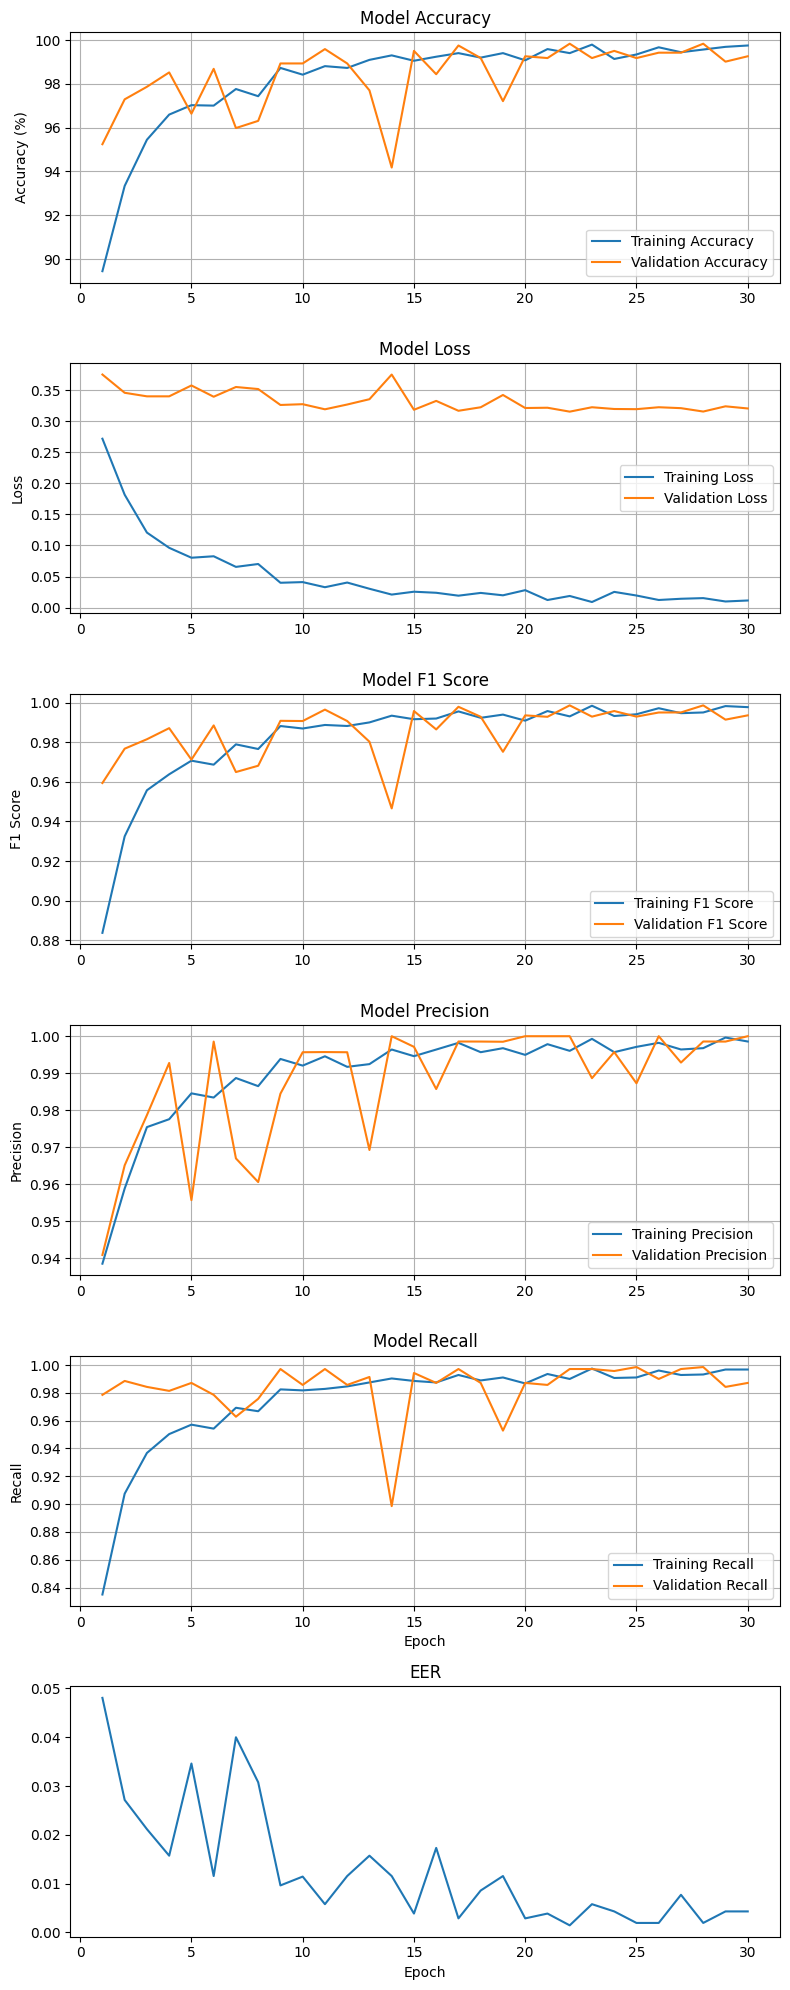

In [ ]:
plt.figure(figsize=(8, 20))

# Accuracy
plt.subplot(6, 1, 1)
plt.plot(range(1, len(history['accuracy']) + 1), history['accuracy'], label='Training Accuracy')
plt.plot(range(1, len(history['val_accuracy']) + 1), history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(6, 1, 2)
plt.plot(range(1, len(history['loss']) + 1), history['loss'], label='Training Loss')
plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# F1 Score
plt.subplot(6, 1, 3)
plt.plot(range(1, len(history['f1_score']) + 1), history['f1_score'], label='Training F1 Score')
plt.plot(range(1, len(history['val_f1_score']) + 1), history['val_f1_score'], label='Validation F1 Score')
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(6, 1, 4)
plt.plot(range(1, len(history['precision']) + 1), history['precision'], label='Training Precision')
plt.plot(range(1, len(history['val_precision']) + 1), history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(6, 1, 5)
plt.plot(range(1, len(history['recall']) + 1), history['recall'], label='Training Recall')
plt.plot(range(1, len(history['val_recall']) + 1), history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

#eer
plt.subplot(6, 1, 6)
plt.plot(range(1, len(history['eer']) + 1), history['eer'], label='EER')
plt.title('EER')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

In [ ]:
import shutil

source_dir = "/content/models"
destination_dir = "/content/drive/MyDrive/30_epoch_Train_Rawnet2_Models"

shutil.copytree(source_dir, destination_dir)

'/content/drive/MyDrive/30_epoch_Train_Rawnet2_Models'

In [9]:
test_df = get_file_df(test_path)
us_path = os.path.join(dataset_path, 'us')

us_df = get_file_df(us_path)

test_df = pd.concat([test_df, us_df], ignore_index=True)

test_df.to_csv("test_metadata.csv", index=False)

# test_df = get_file_df(test_path)
# test_df.to_csv("test_metadata.csv", index=False)


In [ ]:
df_2 = pd.read_csv("test_metadata.csv")
df_2.head()

,path,label,fake_type,gender,id,set,sentence,duration,samples,sr
0,/content/drive/MyDrive/Dataset/Test/Real_M_P29...,0,Real,Male,P29,E,18,5.572789,245760,44100
1,/content/drive/MyDrive/Dataset/Test/Real_M_P29...,0,Real,Male,P29,E,17,8.370794,369152,44100
2,/content/drive/MyDrive/Dataset/Test/Real_M_P29...,0,Real,Male,P29,E,10,5.712109,251904,44100
3,/content/drive/MyDrive/Dataset/Test/Real_M_P29...,0,Real,Male,P29,E,12,6.211338,273920,44100
4,/content/drive/MyDrive/Dataset/Test/Real_M_P29...,0,Real,Male,P29,E,1,7.581315,334336,44100


In [10]:

transform = lambda x: pad(x, max_len=64000)

test_dataset = AudioDataset(test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
test_dataset.__len__()


1650

In [12]:
# config = {
#     'first_conv': 128,
#     'in_channels': 1,
#     'filts': [128, [128, 128], [128, 512]],
#     'nb_fc_node': 1024,
#     'gru_node': 1024,
#     'nb_gru_layer': 3,
#     'nb_classes': 2,
#     'nb_samp': 64000
# }
config = {
    'first_conv': 128,
    'in_channels': 1,
    'filts': [128, [128, 128], [128, 512], [512, 512]],
    'nb_fc_node': 1024,
    'gru_node': 1024,
    'nb_gru_layer': 3,
    'nb_classes': 2,
    'nb_samp': 64000
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RawNet(config, device=device).to(device)

# Load trained weights
model.load_state_dict(torch.load("/content/drive/MyDrive/30_epoch_Train_Rawnet2_Models/best.pth", map_location=device))
model.eval()


y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(device), y.to(device)
        output = model(x, is_test=True)
        prob = output[:, 1]
        preds = torch.argmax(output, dim=1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(prob.cpu().numpy())


Testing: 100%|██████████| 52/52 [00:56<00:00,  1.08s/it]


In [13]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    roc_auc_score, roc_curve, confusion_matrix
)

#  Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_score)
eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
conf_mat = confusion_matrix(y_true, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"EER: {eer:.4f}")

Accuracy: 0.8182
Precision: 0.9565
Recall: 0.7168
F1-score: 0.8195
EER: 0.2116


In [14]:
from sklearn.metrics import classification_report

print(f"=== Classification Report: ===")
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))


=== Classification Report: ===
              precision    recall  f1-score   support

        Real       0.71      0.96      0.82       700
        Fake       0.96      0.72      0.82       950

    accuracy                           0.82      1650
   macro avg       0.83      0.84      0.82      1650
weighted avg       0.85      0.82      0.82      1650



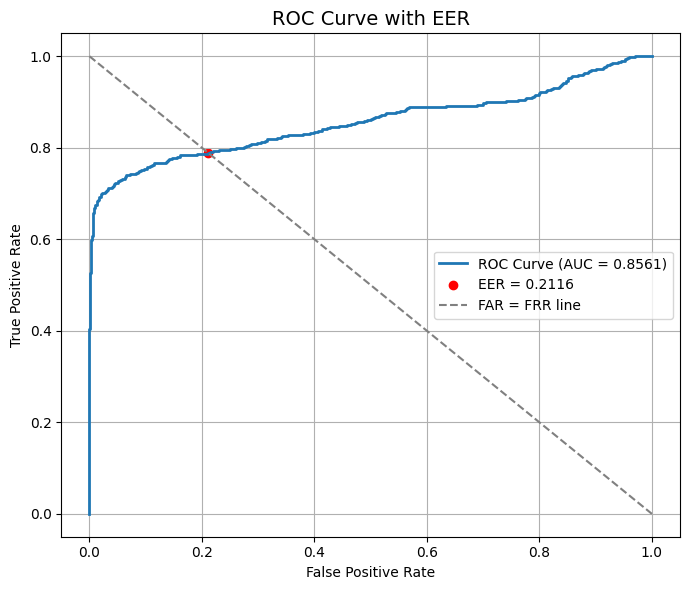

In [27]:
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})", linewidth=2)

# EER point
plt.scatter([eer], [1 - eer], color='red', label=f"EER = {eer:.4f}")
plt.plot([0, 1], [1, 0], linestyle='--', color='gray', label="FAR = FRR line")  # full diagonal

# Labels
plt.title("ROC Curve with EER", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


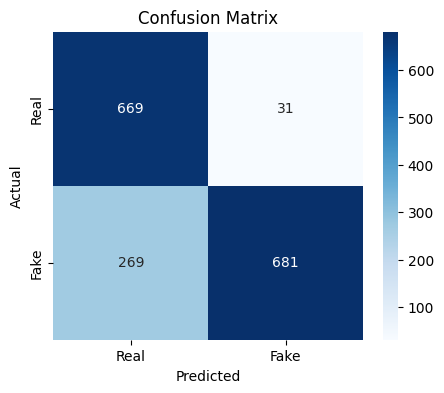

In [28]:


# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<ipython-input-16-1327980502>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette="viridis")


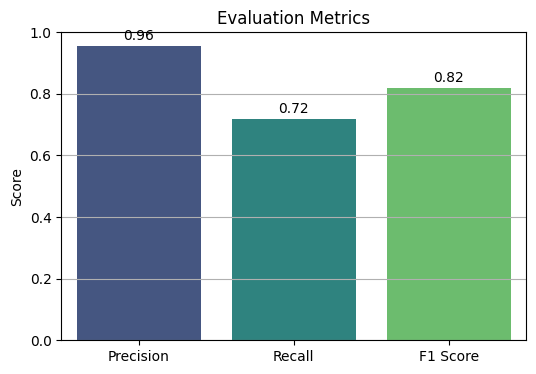

In [16]:
plt.figure(figsize=(6, 4))
scores = [precision, recall, f1]
labels = ['Precision', 'Recall', 'F1 Score']
sns.barplot(x=labels, y=scores, palette="viridis")
plt.ylim(0, 1)
plt.title("Evaluation Metrics")
plt.ylabel("Score")
for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center')
plt.grid(axis='y')
plt.show()

In [17]:

all_preds = []
all_true = []
all_scores = []

model.eval()
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(tqdm(test_loader, desc="Testing")):
        x = x.to(device)
        output = model(x, is_test=True)
        prob = output[:, 1]
        preds = torch.argmax(output, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_true.extend(y.cpu().numpy())
        all_scores.extend(prob.cpu().numpy())

test_df = test_df.reset_index(drop=True)
test_df['y_true'] = all_true
test_df['y_pred'] = all_preds
test_df['y_score'] = all_scores


Testing: 100%|██████████| 52/52 [00:52<00:00,  1.00s/it]


In [18]:
misclassified_df = test_df[test_df['y_true'] != test_df['y_pred']]

missed_by_type = misclassified_df['fake_type'].value_counts()

print("Misclassified Samples by Type:")
print(missed_by_type)


Misclassified Samples by Type:
fake_type
VC      264
Real     31
TTS       5
Name: count, dtype: int64


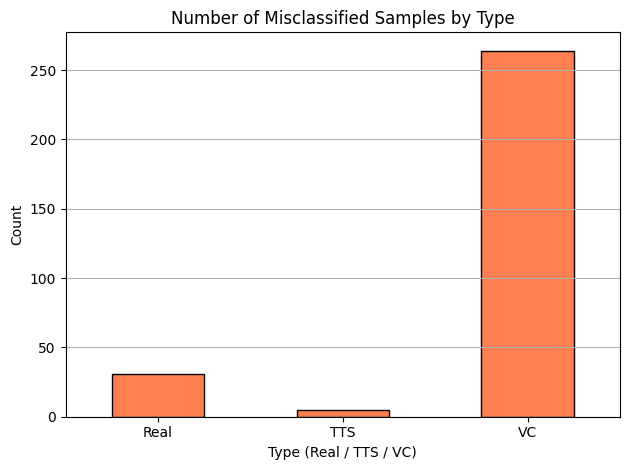

In [19]:
import matplotlib.pyplot as plt

# Plot as bar chart
missed_by_type = missed_by_type.sort_index()
missed_by_type.plot(kind='bar', color='coral', edgecolor='black')
plt.title("Number of Misclassified Samples by Type")
plt.ylabel("Count")
plt.xlabel("Type (Real / TTS / VC)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [20]:
misclassified_df.to_csv("misclassified_samples.csv", index=False)


In [21]:
test_df['pred_type'] = test_df.apply(
    lambda row: row['fake_type'] if row['y_pred'] == 1 else 'Real', axis=1
)


In [22]:
conf_type = pd.crosstab(test_df['fake_type'], test_df['pred_type'])
conf_type = conf_type.reindex(index=['Real', 'TTS', 'VC'], columns=['Real', 'TTS', 'VC'], fill_value=0)


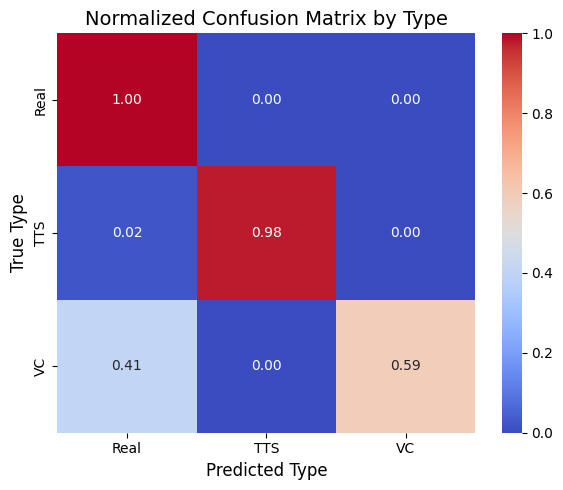

In [23]:


conf_type_percent = conf_type.div(conf_type.sum(axis=1), axis=0).round(2)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_type_percent, annot=True, fmt=".2f", cmap="coolwarm")

plt.xlabel("Predicted Type", fontsize=12)
plt.ylabel("True Type", fontsize=12)
plt.title("Normalized Confusion Matrix by Type", fontsize=14)

plt.tight_layout()
plt.show()
